In [1]:
import glob #to read the files
import json #to work if .json
import numpy as np #to math
import pandas as pd #to save the data
import math #to convertion calculus
from astropy.time import Time #to time converting
from astropy import units #time correction
from astropy.coordinates import SkyCoord #time correction
from scipy import interpolate #to interpolate the wavelength and flux
from tabulate import tabulate #to export in table format
from scipy.interpolate import interp1d
#import scipy.optimize as opt
from scipy import optimize
from scipy import signal
import os.path
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy import stats
import os.path 

In [2]:
name = "SN2001ep.json"

In [3]:
with open(name, "r") as read_file:
    data = json.load(read_file)

In [4]:
url = name
if url.endswith('.json'):
    url = url[:-5]

In [5]:
%run ./functions.ipynb

In [6]:
redshift = redshift_value(data[url])

0.013012


In [7]:
t0 = max_time(data[url])

In [8]:
t0

52193.0

In [9]:
if redshift is not None and t0 is not None:
        
    #spectra data
    i=0
    n=0
    while i < len(data[url]["spectra"]):


        if "time" in data[url]["spectra"][i]:

            spectratime = float(data[url]["spectra"][i]["time"]) - float(t0)
            #print(spectratime)

        alert3 = 0
        #if its the first spectra then previous time is the first time
        if i == 0:
            previoustime = spectratime

        else:
            #if the diference between the time and previous time is more than * days so emmit an alert to continue
            if (spectratime - previoustime) < 2000:

                alert3 = 1
                previoustime = spectratime

            #if the diference of time is less than * continue
        if alert3 == 1:

            #verifing if its calibrated and if it have a redshift correction 
            alert1 = 0 #for calibration
            alert2 = 0 #for redshift correction

            if data[url]["spectra"][i]["u_fluxes"] == "erg/s/cm^2/Angstrom":          
                alert1 = 1 #first alert

                if "deredshifted" in data[url]["spectra"][i]:
                    alert2 = 1 #second alert

            #if its calibrated and corrected
            if alert1 == 1 and alert2 == 1:

                #there are 3 collumns: wavelength flux and flux error 
                if len(data[url]["spectra"][i]["data"][0]) == 3:

                    n = n + 1

                #there are 2 collumns: wavelength and flux
                elif len(data[url]["spectra"][i]["data"][0]) == 2:

                    n = n + 1

            #if its calibrated, redshift not adjusted but with a clear redshift
            elif alert1 ==1 and alert2 == 0:   

                #there are 3 collumns: wavelength flux and flux error 
                if len(data[url]["spectra"][i]["data"][0]) == 3:

                    n = n + 1

                #there are 2 collumns: wavelength and flux
                elif len(data[url]["spectra"][i]["data"][0]) == 2:

                    n = n + 1

        i = i + 1

In [10]:
n

22

In [11]:
final_gradex = np.linspace(-20, 50, 71)
final_gradey = np.linspace(2000, 9200, 721)

In [12]:
x = []
y = []
times = []

if n > 4:

    #print(redshift)
    spectra_data = 0
    i=0
    
    while i < len(data[url]["spectra"]):

        if "time" in data[url]["spectra"][i]:

            spectratime = float(data[url]["spectra"][i]["time"]) - float(t0)
            #print(spectratime)
            #verifing if its calibrated and if it have a redshift correction 
            alert1 = 0 #for calibration
            alert2 = 0 #for redshift correction

            if data[url]["spectra"][i]["u_fluxes"] == "erg/s/cm^2/Angstrom":          
                alert1 = 1 #first alert

                if "deredshifted" in data[url]["spectra"][i]:
                    alert2 = 1 #second alert

            #if its calibrated and corrected
            if alert1 == 1 and alert2 == 1:
                #print("ok")
                #there are 3 collumns: wavelength flux and flux error
                if len(data[url]["spectra"][i]["data"][0]) == 3:

                    df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux', 'fluxerror'])

                    #converting to float
                    df['wavelength'] = df['wavelength'].astype(float)
                    df['flux'] = df['flux'].astype(float)
                    
                    
                    #sort the data by wavelength
                    df = df.sort_values(by=['wavelength'])
                    df = df.reset_index(drop=True)

                    #to kill negative fluxes
                    fluxtemp = []
                    for var in range(0,len(df['flux'])):
                        if (df['flux'][var] > 0):
                            fluxtemp.append(df['flux'][var])
                        else:
                            fluxtemp.append(0)            
         
                    #making a list of lists 
                    
                    suavf = suavization(fluxtemp)
                            
                    if "instrument" in data[url]["spectra"][i]:
                                
                        if data[url]["spectra"][i]["instrument"] == "fast":
                            
                            x.append(df['wavelength'])
                            y.append(suavf)
                            times.append(spectratime)
                            
                            
                
                
                #there are 2 collumns: wavelength and flux
                if len(data[url]["spectra"][i]["data"][0]) == 2:

                    df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux'])

                    #converting to float
                    df['wavelength'] = df['wavelength'].astype(float)
                    df['flux'] = df['flux'].astype(float)
                    
                    
                    #sort the data by wavelength
                    df = df.sort_values(by=['wavelength'])
                    df = df.reset_index(drop=True)

                    #to kill negative fluxes
                    fluxtemp = []
                    for var in range(0,len(df['flux'])):
                        if (df['flux'][var] > 0):
                            fluxtemp.append(df['flux'][var])
                        else:
                            fluxtemp.append(0)            
      
                    #making a list of lists 
                    suavf = suavization(fluxtemp)
                    if "instrument" in data[url]["spectra"][i]:
                                
                        if data[url]["spectra"][i]["instrument"] == "fast":
                            
                            x.append(df['wavelength'])
                            y.append(suavf)
                            times.append(spectratime)
                            

                    
            #if its calibrated, redshift not adjusted but with a clear redshift
            if alert1 ==1 and alert2 == 0:  
                
                #there are 3 collumns: wavelength flux and flux error 
                if len(data[url]["spectra"][i]["data"][0]) == 3:

                    df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux', 'fluxerror'])

                    #converting to float
                    df['wavelength'] = df['wavelength'].astype(float)
                    df['flux'] = df['flux'].astype(float)
                    
                    
                    #sort the data by wavelength
                    df = df.sort_values(by=['wavelength'])
                    df = df.reset_index(drop=True)

                    #to kill negative fluxes
                    fluxtemp = []
                    for var in range(0,len(df['flux'])):
                        if (df['flux'][var] > 0):
                            fluxtemp.append(df['flux'][var])
                        else:
                            fluxtemp.append(0)


                    #redshift correction
                    fluxtemp = [x * (((1+redshift))**3) for x in fluxtemp] #for the flux           
                    df['wavelength'] = [x * (1/(1+redshift)) for x in df['wavelength']] #for the wavelength
                    spectratime = spectratime/(1+redshift) #for time
         
                    #making a list of lists 
                    suavf = suavization(fluxtemp)
                
                    if "instrument" in data[url]["spectra"][i]:
                                
                        if data[url]["spectra"][i]["instrument"] == "fast":
                            
                            x.append(df['wavelength'])
                            y.append(suavf)
                            times.append(spectratime)
                            
                    
                #there are 2 collumns: wavelength flux and flux error 
                if len(data[url]["spectra"][i]["data"][0]) == 2:

                    df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux'])

                    #converting to float
                    df['wavelength'] = df['wavelength'].astype(float)
                    df['flux'] = df['flux'].astype(float)
                    
                    
                    #sort the data by wavelength
                    df = df.sort_values(by=['wavelength'])
                    df = df.reset_index(drop=True)

                    #to kill negative fluxes
                    fluxtemp = []
                    for var in range(0,len(df['flux'])):
                        if (df['flux'][var] > 0):
                            fluxtemp.append(df['flux'][var])
                        else:
                            fluxtemp.append(0)

                    #redshift correction
                    fluxtemp = [x * (((1+redshift))**3) for x in fluxtemp] #for the flux           
                    df['wavelength'] = [x * (1/(1+redshift)) for x in df['wavelength']] #for the wavelength
                    spectratime = spectratime/(1+redshift) #for time
       
                    #making a list of lists 
                    suavf = suavization(fluxtemp)
            
                    if "instrument" in data[url]["spectra"][i]:
                                
                        if data[url]["spectra"][i]["instrument"] == "fast":
                            
                            x.append(df['wavelength'])
                            y.append(suavf)
                            times.append(spectratime)
                            
                            
        i = i + 1


## Curvas de luz não integradas

In [13]:
len(x)

23

In [19]:
wavenumber = 6500

In [20]:
time = []
flux = []

In [21]:
for i in range(0,len(times)):
    
    if min(x[i]) < wavenumber < max(x[i]):
    
        interpolation = interp1d(x[i], y[i])
        
        time.append(times[i])
        flux.append(interpolation(wavenumber))
        

<IPython.core.display.Javascript object>


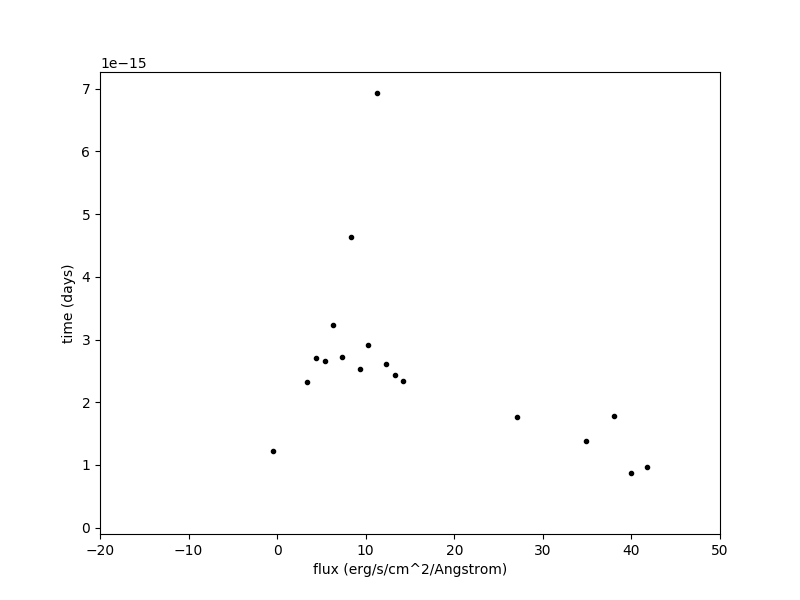

In [22]:
%matplotlib notebook

plt.figure(figsize=(8,6))
plt.plot(time, flux,'k.')
plt.xlabel('flux (erg/s/cm^2/Angstrom)')
plt.ylabel('time (days)')
plt.xlim(-20,50)
plt.show()

In [18]:

save_path = '/home/joao/Documentos/templates/data'

for i in range(0,len(x)):
    
    table = []
    for k in range(0,len(x[i])):
        table.append((x[i][k], y[i][k]))


    name_of_file = str(url)

    completeName = os.path.join(save_path, name_of_file+str(i)+".dat")      

    header = '#' + str(times[i])
    
    f = open(completeName, 'w')               
    f.write(header + "\n")
    f.write(tabulate(table, tablefmt="plain"))
    f.close()
    

    
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
